# Build your own Experiment

#### imports

In [ ]:
from config import EXPERIMENTAL_DATA_PATH, SAVE_PATH
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv


## Pre treatment of raw data from experiment

#### Merge every participant's csv

In [2]:
csv_files = glob.glob(os.path.join(EXPERIMENTAL_DATA_PATH, "*.csv"))
print(f"Fichiers trouvés: {csv_files}")

all_data = []
for file in csv_files:
    df = pd.read_csv(file)
    all_data.append(df)

df_combined = pd.concat(all_data, ignore_index=True)

df = df_combined.pivot_table(
    index=['reference', 'condition'],
    columns='participant',
    values='rating',
    aggfunc='first'
).reset_index()

df.columns = ['video', 'condition'] + [f'rating_{col}' for col in df.columns[2:]]

print(f"\nDataframe final: {df.shape}")
print(df.head(10))

Fichiers trouvés: ['data\\cbuze_01_samviq.csv', 'data\\christopher_01_samviq.csv', 'data\\d_01_samviq.csv', 'data\\lou-anne_01_samviq.csv']

Dataframe final: (36, 6)
                 video condition  rating_cbuze  rating_christopher  rating_d  \
0  Center_Book_arrival    Fehn_c            46                  22        60   
1  Center_Book_arrival    Fehn_i            23                  35        65   
2  Center_Book_arrival     Holes            94                  79        65   
3  Center_Book_arrival  ICIP_TMM            54                  48        62   
4  Center_Book_arrival      ICME            48                  65        65   
5  Center_Book_arrival  Original            77                   5        67   
6      Center_Lovebird    Fehn_c            50                  26        52   
7      Center_Lovebird    Fehn_i            48                  46        51   
8      Center_Lovebird     Holes            47                  76        49   
9      Center_Lovebird  ICIP_TMM  

#### Video path

In [3]:
def find_video(originals, ref, condition, data):
    to_cam_position, video_label = ref.split('_', 1)
    if condition == 'Original':
        filtre = (
            (data['Algo'] == condition) &
            (data['from_cam_position'] == originals) &
            (data['Video'].str.contains(video_label, case=False, na=False))
        )
    else :
        filtre = (
            (data['Algo'] == condition) &
            (data['from_cam_position'] == originals) &
            (data['to_cam_position'] == to_cam_position) &
            (data['Video'].str.contains(video_label, case=False, na=False))
        )
    candidates = data.loc[filtre, 'Video_path']
    if candidates.empty:
        print(f"No video found for {originals}, {ref}, {condition}")
    return candidates.iloc[0] if not candidates.empty else None


#### MOS/DMOS

In [4]:
# Calcul du MOS (Mean Opinion Score)
rating_cols = [col for col in df.columns if col.startswith("rating_")]
df["MOS"] = df[rating_cols].mean(axis=1)

# Calcul du DMOS (Differential Mean Opinion Score)
reference_mos = df[df["condition"] == "Original"].groupby("video")["MOS"].mean()
df = df.join(reference_mos, on="video", rsuffix="_ref")
df["DMOS"] = df["MOS_ref"] - df["MOS"] + 20 ##############################TODO à ajuster

df.drop(columns=["MOS_ref"], inplace=True)

print(df[["video", "condition", "MOS", "DMOS"]].head())


                 video condition    MOS   DMOS
0  Center_Book_arrival    Fehn_c  52.75  28.50
1  Center_Book_arrival    Fehn_i  38.50  42.75
2  Center_Book_arrival     Holes  62.75  18.50
3  Center_Book_arrival  ICIP_TMM  55.00  26.25
4  Center_Book_arrival      ICME  49.25  32.00


In [5]:
df["STD"] = df[rating_cols].std(axis=1)
nb_participants = len(rating_cols)
df["CI_95"] = 1.96 * df["STD"] / np.sqrt(nb_participants)
df.drop(columns=["STD"], inplace=True)


## save

In [15]:
output_file = os.path.join(SAVE_PATH, "experimental_results.csv")
df.to_csv(output_file, index=False)
print(f"\nDataframe sauvegardé dans: {output_file}")


Dataframe sauvegardé dans: results/experimental_results.csv


## Statistical analysis of MOS and CI

#### MOS and CI visualization

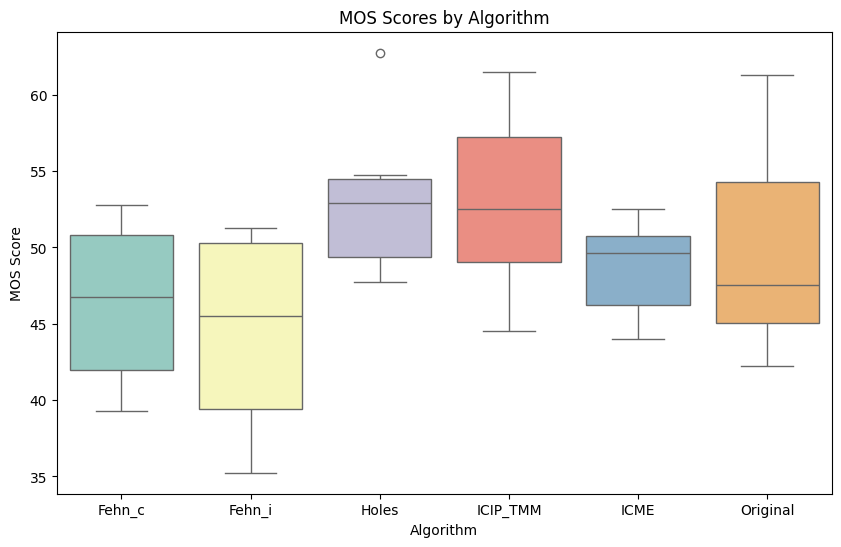

In [7]:
plt.figure(figsize=(10,6))
sns.boxplot(x="condition", y="MOS", data=df, hue="condition", palette="Set3", legend=False)
plt.title("MOS Scores by Algorithm")
plt.xlabel("Algorithm")
plt.ylabel("MOS Score")
plt.show()

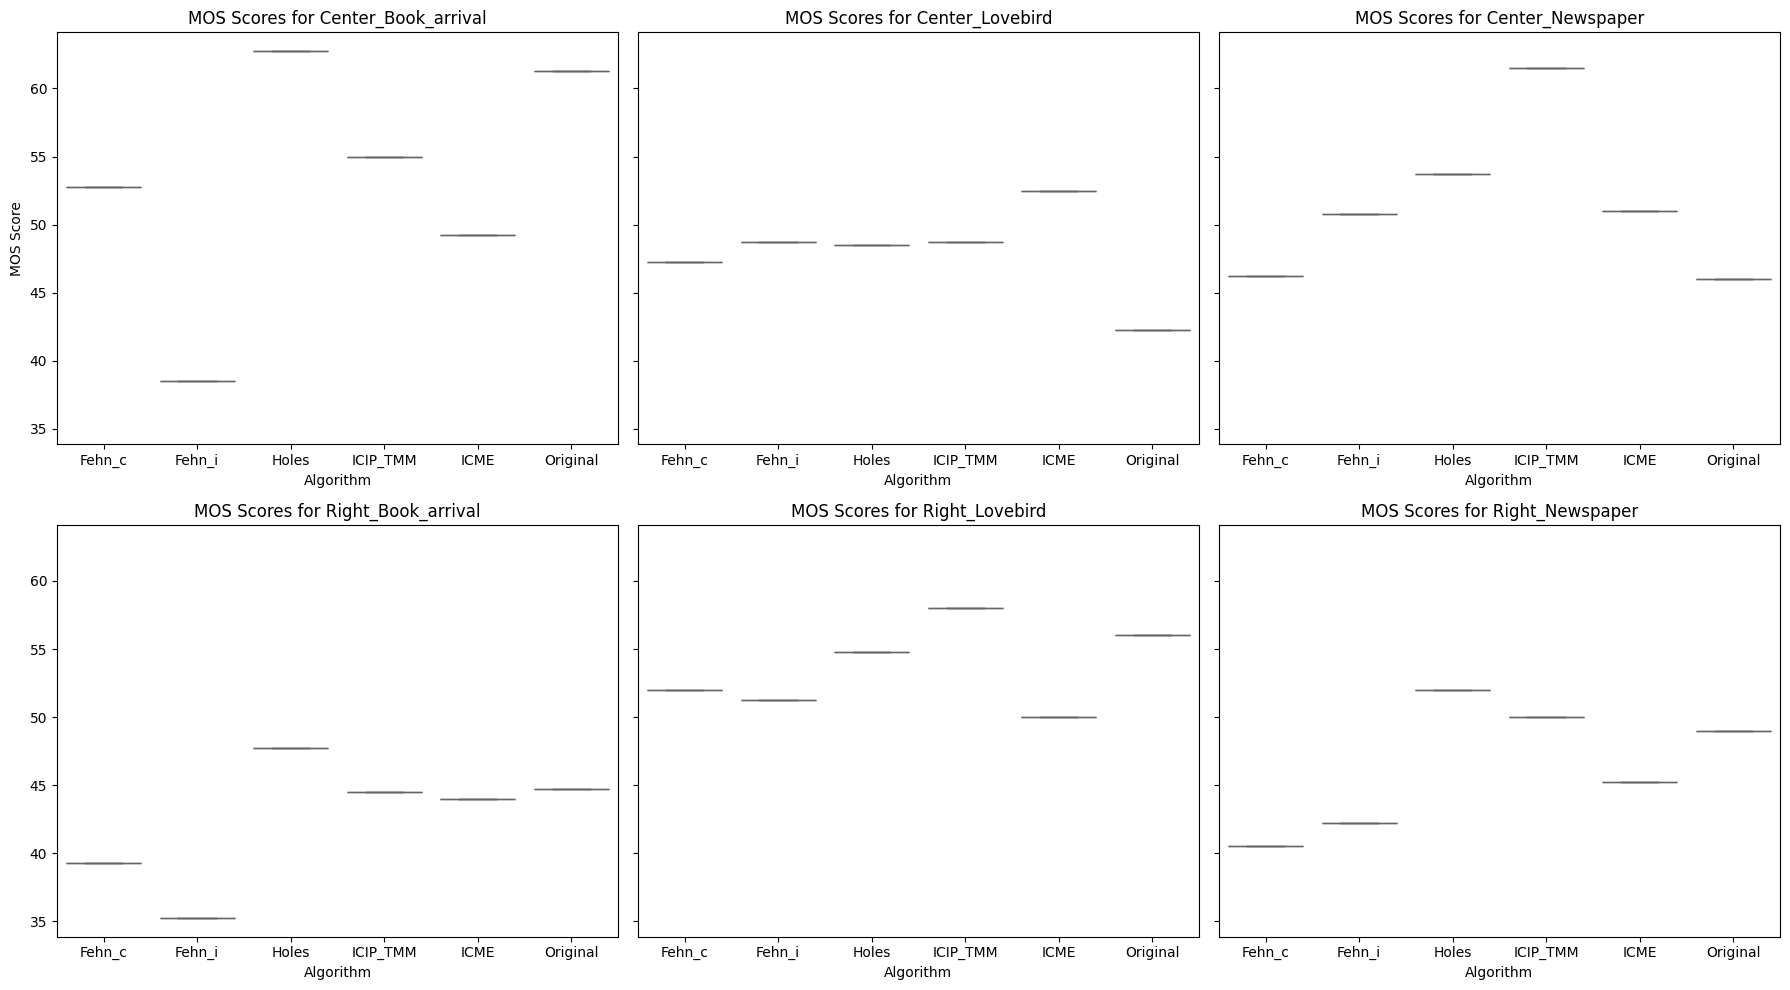

In [8]:
video_ids = df["video"].unique()
fig, axes = plt.subplots(2, 3, figsize=(18,10), sharey=True)
for i, video_id in enumerate(video_ids):
    ax = axes[i // 3, i % 3]
    subset = df[df["video"] == video_id]
    sns.boxplot(x="condition", y="MOS", data=subset, hue="condition", palette="Set3", ax=ax, legend=False)
    ax.set_title(f"MOS Scores for {video_id}")
    ax.set_xlabel("Algorithm")
    if i == 0:
        ax.set_ylabel("MOS Score")
    else:
        ax.set_ylabel("")
plt.tight_layout()
plt.show()

In [9]:
# Display MOS and CI from dataframe
print("Algorithm\t\tMean MOS ± CI")
print("-" * 50)
for algo in sorted(df['condition'].unique()):
    subset = df[df['condition'] == algo]
    mean_mos = subset['MOS'].mean()
    mean_ci = subset['CI_95'].mean()
    print(f"{algo:15s}\t{mean_mos:.3f} ± {mean_ci:.3f}  [{mean_mos-mean_ci:.3f}, {mean_mos+mean_ci:.3f}]")

Algorithm		Mean MOS ± CI
--------------------------------------------------
Fehn_c         	46.333 ± 16.283  [30.050, 62.616]
Fehn_i         	44.458 ± 13.800  [30.658, 58.258]
Holes          	53.250 ± 32.943  [20.307, 86.193]
ICIP_TMM       	52.958 ± 18.661  [34.298, 71.619]
ICME           	48.667 ± 22.397  [26.269, 71.064]
Original       	49.875 ± 39.197  [10.678, 89.072]


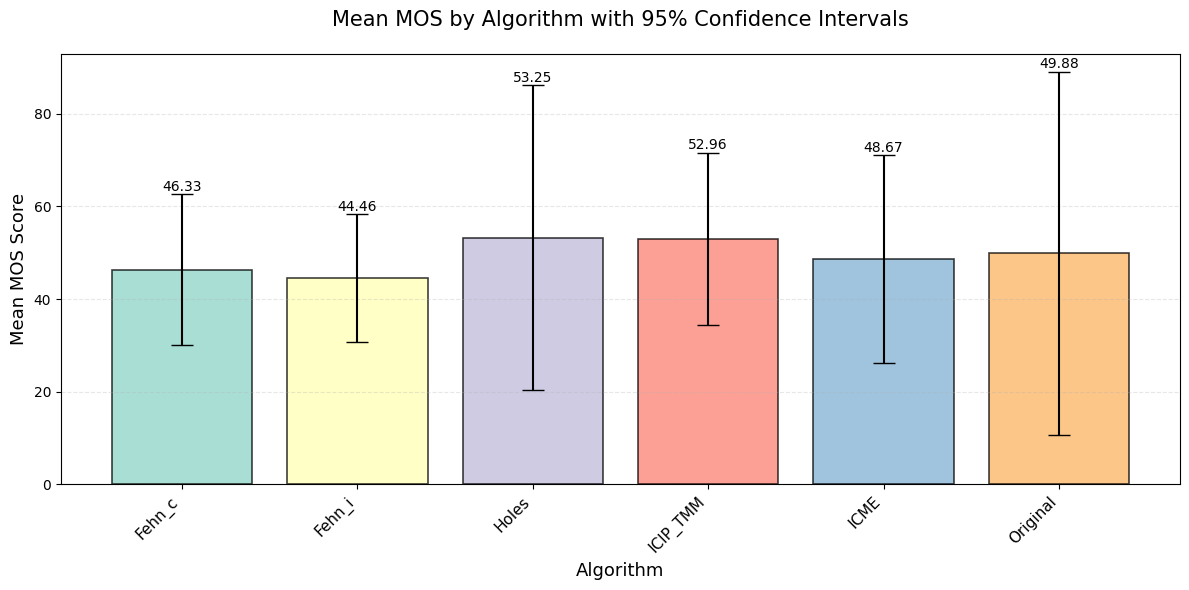

Non-overlapping CIs suggest statistically significant differences


In [10]:
# Visualization of Mean MOS with CI from dataframe
fig, ax = plt.subplots(figsize=(12, 6))

# Get means and CIs from dataframe
algos = sorted(df['condition'].unique())
means = []
cis = []

for algo in algos:
    subset = df[df['condition'] == algo]
    means.append(subset['MOS'].mean())
    cis.append(subset['CI_95'].mean())

# Create bar plot with error bars
x_pos = np.arange(len(algos))
bars = ax.bar(x_pos, means, yerr=cis, capsize=8, alpha=0.75, 
               color=sns.color_palette("Set3", len(algos)), 
               edgecolor='black', linewidth=1.2)

# Add value labels on bars
for i, (m, c) in enumerate(zip(means, cis)):
    ax.text(i, m + c + 0.05, f'{m:.2f}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Algorithm', fontsize=13)
ax.set_ylabel('Mean MOS Score', fontsize=13)
ax.set_title('Mean MOS by Algorithm with 95% Confidence Intervals', fontsize=15, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(algos, rotation=45, ha='right', fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(means) + max(cis) + 0.5)

plt.tight_layout()
plt.show()


print("Non-overlapping CIs suggest statistically significant differences")

#### Anova

In [11]:
# Statistical comparison: ANOVA test to check if there are significant differences between algorithms
from scipy.stats import f_oneway

# Prepare data for ANOVA
algo_groups = [group['MOS'].values for name, group in df.groupby('condition')]

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(*algo_groups)

print(f"One-Way ANOVA Results:")
print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("\nConclusion: There are statistically significant differences between algorithms (p < 0.05)")
else:
    print("\nConclusion: No statistically significant differences between algorithms (p >= 0.05)")

One-Way ANOVA Results:
F-statistic: 2.1077
P-value: 0.0919444881724739

Conclusion: No statistically significant differences between algorithms (p >= 0.05)


In [12]:
#test de Dunnett
from statsmodels.stats.multicomp import pairwise_tukeyhsd
dunnett = pairwise_tukeyhsd(endog=df['MOS'], groups=df['condition'], alpha=0.05)
print(dunnett)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower    upper  reject
---------------------------------------------------------
  Fehn_c   Fehn_i   -1.875 0.9936 -12.3041  8.5541  False
  Fehn_c    Holes   6.9167 0.3567  -3.5124 17.3458  False
  Fehn_c ICIP_TMM    6.625 0.4033  -3.8041 17.0541  False
  Fehn_c     ICME   2.3333 0.9828  -8.0958 12.7624  False
  Fehn_c Original   3.5417  0.903  -6.8874 13.9708  False
  Fehn_i    Holes   8.7917 0.1379  -1.6374 19.2208  False
  Fehn_i ICIP_TMM      8.5 0.1626  -1.9291 18.9291  False
  Fehn_i     ICME   4.2083 0.8201  -6.2208 14.6374  False
  Fehn_i Original   5.4167 0.6175  -5.0124 15.8458  False
   Holes ICIP_TMM  -0.2917    1.0 -10.7208 10.1374  False
   Holes     ICME  -4.5833 0.7627 -15.0124  5.8458  False
   Holes Original   -3.375 0.9194 -13.8041  7.0541  False
ICIP_TMM     ICME  -4.2917 0.8079 -14.7208  6.1374  False
ICIP_TMM Original  -3.0833 0.9437 -13.5124  7.3458  False
    ICME Origi

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

mc = MultiComparison(df['MOS'], df['condition'])

result = mc.tukeyhsd()

filtered_results = result.summary().data[1:] 
filtered_results = [row for row in filtered_results if 'Original' in row[0] or 'Original' in row[1]]
for rows in filtered_results:
    print(rows)

['Fehn_c', 'Original', np.float64(3.5417), np.float64(0.903), np.float64(-6.8874), np.float64(13.9708), np.False_]
['Fehn_i', 'Original', np.float64(5.4167), np.float64(0.6175), np.float64(-5.0124), np.float64(15.8458), np.False_]
['Holes', 'Original', np.float64(-3.375), np.float64(0.9194), np.float64(-13.8041), np.float64(7.0541), np.False_]
['ICIP_TMM', 'Original', np.float64(-3.0833), np.float64(0.9437), np.float64(-13.5124), np.float64(7.3458), np.False_]
['ICME', 'Original', np.float64(1.2083), np.float64(0.9992), np.float64(-9.2208), np.float64(11.6374), np.False_]


In [14]:
print("=" * 70)
print("SUMMARY: Comparison of Each Algorithm vs. Original (Control)")
print("=" * 70)
print(f"{'Algorithm':<15} {'Mean Diff':<17} {'95% CI':<12} {'p-value':<6} {'Significant?'}")
print("-" * 70)

for row in filtered_results:
    group1, group2, meandiff, pval, lower, upper, reject = row
    if 'Original' in [group1, group2]:
        other_group = group1 if group2 == 'Original' else group2
        meandiff_adj = meandiff if group1 == 'Original' else -meandiff
        lower_adj = lower if group1 == 'Original' else -lower
        upper_adj = upper if group1 == 'Original' else -upper
        
        ci_str = f"[{lower_adj:6.3f}, {upper_adj:6.3f}]"
        sig_str = "YES" if reject else "NO"
        
        print(f"{other_group:<15} {meandiff_adj:>10.4f}  {ci_str:<20} {pval:>6}  {sig_str}")

print("=" * 70)
print("\nInterpretation:")
print("- Positive Mean Diff: Algorithm performs BETTER than Original")
print("- Negative Mean Diff: Algorithm performs WORSE than Original")
print("- Significant (p < 0.05): The difference is statistically meaningful")

SUMMARY: Comparison of Each Algorithm vs. Original (Control)
Algorithm       Mean Diff         95% CI       p-value Significant?
----------------------------------------------------------------------
Fehn_c             -3.5417  [ 6.887, -13.971]     0.903  NO
Fehn_i             -5.4167  [ 5.012, -15.846]    0.6175  NO
Holes               3.3750  [13.804, -7.054]     0.9194  NO
ICIP_TMM            3.0833  [13.512, -7.346]     0.9437  NO
ICME               -1.2083  [ 9.221, -11.637]    0.9992  NO

Interpretation:
- Positive Mean Diff: Algorithm performs BETTER than Original
- Negative Mean Diff: Algorithm performs WORSE than Original
- Significant (p < 0.05): The difference is statistically meaningful


## SI/TI

#### Def

In [ ]:
def calculate_SI(frame):
    """
    Calculate Spatial Information (SI) for a frame.
    SI measures the spatial complexity/detail in the frame.
    
    SI = std(Sobel(frame))
    Higher SI = more spatial detail/edges
    """
    # Convert to grayscale if needed
    if len(frame.shape) == 3:
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    else:
        gray = frame
    
    # Apply Sobel operator to detect edges
    sobel_x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=3)
    sobel_y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # SI is the standard deviation of the Sobel filtered frame
    si = np.std(sobel)
    return si

def calculate_TI(frame1, frame2):
    """
    Calculate Temporal Information (TI) between two consecutive frames.
    TI measures the amount of motion/change between frames.
    
    TI = std(frame_diff)
    Higher TI = more motion/temporal change
    """
    # Convert to grayscale if needed
    if len(frame1.shape) == 3:
        gray1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    else:
        gray1 = frame1
        gray2 = frame2
    
    # Calculate frame difference
    diff = gray2.astype(np.float64) - gray1.astype(np.float64)
    
    # TI is the standard deviation of the frame difference
    ti = np.std(diff)
    return ti

def analyze_video_SI_TI(video_path, max_frames=300):
    """
    Analyze a video and return its SI and TI values.
    
    Parameters:
    - video_path: path to video file
    - max_frames: maximum number of frames to analyze (for efficiency)
    
    Returns:
    - mean_si: average SI across frames
    - max_si: maximum SI value
    - mean_ti: average TI across frame pairs
    - max_ti: maximum TI value
    """
    cap = cv.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return None, None, None, None
    
    si_values = []
    ti_values = []
    prev_frame = None
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret or frame_count >= max_frames:
            break
        
        # Calculate SI for current frame
        si = calculate_SI(frame)
        si_values.append(si)
        
        # Calculate TI if we have a previous frame
        if prev_frame is not None:
            ti = calculate_TI(prev_frame, frame)
            ti_values.append(ti)
        
        prev_frame = frame.copy()
        frame_count += 1
    
    cap.release()
    
    # Mean, max and 95th percentile
    mean_si = np.mean(si_values) if si_values else 0
    max_si = np.max(si_values) if si_values else 0
    mean_ti = np.mean(ti_values) if ti_values else 0
    max_ti = np.max(ti_values) if ti_values else 0
    p95_si = np.percentile(si_values, 95) if si_values else 0
    p95_ti = np.percentile(ti_values, 95) if ti_values else 0
    
    return mean_si, max_si, p95_si, mean_ti, max_ti, p95_ti

#### SI/TI computation

In [ ]:
# Calculate SI/TI for all videos in the dataset
df['SI_mean'] = 0.0
df['SI_max'] = 0.0
df['TI_mean'] = 0.0
df['TI_max'] = 0.0
df['SI_p95'] = 0.0
df['TI_p95'] = 0.0

print("Calculating SI/TI for all videos...")
print("This may take a few minutes...\n")

for index, row in df.iterrows():
    video_name = row['Video_path']
    video_path = os.path.join(VIDEOS_PATH, video_name)
    #print(f"Video path: {video_path}")  
    
    if os.path.exists(video_path):
        #print(f"Processing: {video_name[:50]}...")
        mean_si, max_si, p95_si, mean_ti, max_ti, p95_ti = analyze_video_SI_TI(video_path)
        
        df.at[index, 'SI_mean'] = mean_si
        df.at[index, 'SI_max'] = max_si
        df.at[index, 'TI_mean'] = mean_ti
        df.at[index, 'TI_max'] = max_ti
        df.at[index, 'SI_p95'] = p95_si
        df.at[index, 'TI_p95'] = p95_ti

        # If we have values == 0, we can print a warning
        if mean_si == 0:
            print(f"Warning: SI is zero for video: {video_name}")
        if mean_ti == 0:
            print(f"Warning: TI is zero for video: {video_name}")
    else:
        print(f"Video not found: {video_path}")

print("\nSI/TI calculation complete")
print("\nSample results:")
print(df[['Video_path', 'condition', 'MOS', 'SI_mean', 'TI_mean']].head(10))

In [ ]:
df.to_csv(output_path, index=False)
print(f"Data saved to: {output_path}")
print(f"Rows saved: {len(df)}")
print(f"Columns saved: {list(df.columns)}")

#### Plots

In [ ]:
# Visualization 1: SI/TI scatter plot colored by algorithm
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

subset = df[df['condition'] == 'Original']

# Plot 1: SI/TI colored by Source
sources = subset['video'].unique()
colors = sns.color_palette("Set1", len(sources))
for i, source in enumerate(sources):
    source_data = subset[subset['video'] == source]
    axes[0].scatter(source_data['SI_mean'], source_data['TI_mean'], 
                    label=source, color=colors[i], alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Colored by Source', fontsize=13)
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].legend(loc='upper right', fontsize=9)

# Plot 2: SI/TI colored by MOS
scatter = axes[1].scatter(subset['SI_mean'], subset['TI_mean'], 
                         c=subset['MOS'], cmap='RdYlGn', 
                         s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Colored by MOS Score', fontsize=13)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('MOS Score', fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
# Visualization 1: SI/TI scatter plot colored by algorithm
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: SI/TI space
for algo in sorted(df['condition'].unique()):
    subset = df[df['condition'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')

# Plot 2: SI/TI colored by MOS
scatter = axes[1].scatter(df['SI_mean'], df['TI_mean'], 
                         c=df['MOS'], cmap='RdYlGn', 
                         s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Colored by MOS Score', fontsize=13)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('MOS Score', fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each point represents one video")
print("- High SI = spatially complex content (detailed scenes)")
print("- High TI = high motion content")
print("- Colors in right plot show if high SI/TI correlates with lower/higher MOS")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for algo in sorted(df['condition'].unique()):
    subset = df[df['condition'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(loc='right', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')

for source in sorted(df['video'].unique()):
    subset = df[df['video'] == source]
    scatter = axes[1].scatter(subset['SI_mean'], subset['TI_mean'],  label = source, 
                             alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Video Content Characterization by Source', fontsize=13)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].legend(loc='right', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Same graph but without Holes because it skews the scale
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for algo in sorted(df['condition'].unique()):
    if algo == "Holes":
        continue
    subset = df[df['condition'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space without Holes: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')
for source in sorted(df['video'].unique()):
    subset = df[df['video'] == source]
    scatter = axes[1].scatter(subset['SI_mean'], subset['TI_mean'],  label = source, 
                             alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space without Holes: Video Content Characterization by Source', fontsize=13)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()